<a href="https://colab.research.google.com/github/dlfelps/ml_portfolio/blob/main/adversarial_ai_cub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to attack machine learning models.

It has a companion [blog post](https://dlfelps.github.io/2024/07/01/adversarial.html).

It is part of Daniel Felps' [ML portfolio](https://github.com/dlfelps/ml_portfolio/tree/main)

# SETUP ENVIRONMENT

In [1]:
%%capture
!pip install pytorchcv

In [2]:
%%capture
!pip install adversarial-robustness-toolbox[pytorch_image]

In [3]:
%%capture
!git clone https://github.com/dlfelps/datasets.git

In [4]:
%%capture
!git clone https://github.com/dlfelps/adversarial_birds.git

# IMPORTS

In [5]:
from pytorchcv.model_provider import get_model
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from datasets.CUB200 import CUB200
from tqdm import tqdm
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

from art.attacks import EvasionAttack
from art.attacks.evasion import ProjectedGradientDescentPyTorch,CarliniLInfMethod,CarliniL0Method
from art.estimators.classification import PyTorchClassifier


# LOAD DATA

In [6]:
temp = CUB200('.', download=True, is_test=True)
class_mapper = temp.get_id_class_mapper()

cub_dataset = CUB200('.',
                     download=True,
                     is_test=True,
                     target_transform = lambda x : class_mapper[x],
                     transform = v2.Compose([v2.Resize((224,224)),
                                             v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
                                             v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
                                             v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))


100%|██████████| 1150585339/1150585339 [00:42<00:00, 27057062.73it/s]


Extracting ./CUB_200_2011.tgz to .
Files already downloaded and verified


# LOAD MODEL

In [7]:
cub_res = get_model('resnet18_cub', pretrained=True, root='.')
# cub_res.load_state_dict(torch.load('/content/drive/MyDrive/models/resnet18_cub.pt'))
cub_res.eval()

def model_predict(model, input):
  if len(input.shape) == 3:
    input = input.unsqueeze(0)

  with torch.no_grad():
    y = model(input)
    _, preds = torch.max(y,1)
    return preds


# SELECT ATTACK

In [8]:
from enum import Enum

class EvAttack(Enum):
  PGD = ProjectedGradientDescentPyTorch
  CWInf = CarliniLInfMethod
  CW0 = CarliniL0Method

attack = EvAttack.PGD.value # change selection here
# attack = EvAttack.CWInf.value # change selection here
# attack = EvAttack.CW0.value # change selection here

# BUILD ADVERSARIAL IMAGE GENERATOR

This generator takes the following inputs:


*   target model
*   selected attack
*   dataset

Then for a given index (matching the dataset) it either returns an image or None.

*   If an image, then the adversarial attack successfully altered the model's prediction
*   If None, then the model's prediction was unaltered.



In [9]:
from adversarial_birds.adversarial_image_gen import AdvImageGen, undo_normalization

generator = AdvImageGen(cub_res, attack, cub_dataset, undo_redo=True)

Find an image to attack by selecting idx

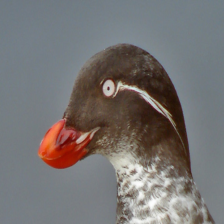

In [10]:
idx = 202
undo_normalization(cub_dataset[idx][0])

Then run the generator (it may take up to a minute depending on the selected attack)

/usr/local/lib/python3.10/dist-packages/art/attacks/evasion/projected_gradient_descent/projected_gradient_descent_pytorch.py:504: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  values_tmp = values_tmp.sign() * torch.minimum(values_tmp.abs(), torch.Tensor(eps))


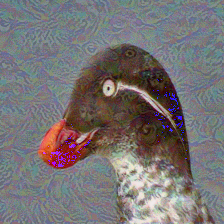

In [11]:
generator[idx]